# Decision Tree Project Tutorial

In [3]:
# Loading Librarires

import pandas as pd
import numpy as np

from IPython import get_ipython
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# modelado
from sklearn.linear_model import LogisticRegression

# metricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

# optimizar
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# modelos
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# save
from pickle import dump

In [4]:
# Set a random seed to ensure reproducibility across runs
RNG_SEED = 42
np.random.seed(seed=RNG_SEED)


# STEP 1) Connect to the database and convert it to a dataframe
resource_url = "https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv"
df = pd.read_csv(resource_url, delimiter=',')

# STEP 2) Problem statement:
print("Problem statement: to predict, based on diagnostic measures, whether or not a patient has diabetes.")

df = df.rename(columns = {'Outcome': 'has_diabetes'})

df.head()



Problem statement: to predict, based on diagnostic measures, whether or not a patient has diabetes.


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,has_diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
#STEP 3) First data overiew: data status
df.info()

print(f"\n There are {df.isnull().any().sum()} columns with missing values in the database {', '.join(df.columns[df.isnull().any()])}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   has_diabetes              768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

 There are 0 columns with missing values in the database 


In [6]:
# STEP 4) First data overiew: Identifying value ranges
'''
1. `non_varying_cols = [col for col in df.columns if df[col].nunique() == 1]`:
  This line uses a list comprehension to iterate through each column (`col`) in the DataFrame (`df.columns`).
2. `df[col].nunique() == 1`: For each column, it checks if the number of unique values (`nunique()`) is equal to 1.
  If this condition is true, it means the column has only one unique value and is considered non-varying.
3. `[col for ... if ...]`: The list comprehension creates a list (`non_varying_cols`)
  containing the names of all columns that satisfy the condition (having only one unique value).
'''

for col in df.columns:
    min_value = df[col].min()
    max_value = df[col].max()
    print(f"Column '{col}' min. value is {min_value} and max. value is {max_value}")
df.head()


Column 'Pregnancies' min. value is 0 and max. value is 17
Column 'Glucose' min. value is 0 and max. value is 199
Column 'BloodPressure' min. value is 0 and max. value is 122
Column 'SkinThickness' min. value is 0 and max. value is 99
Column 'Insulin' min. value is 0 and max. value is 846
Column 'BMI' min. value is 0.0 and max. value is 67.1
Column 'DiabetesPedigreeFunction' min. value is 0.078 and max. value is 2.42
Column 'Age' min. value is 21 and max. value is 81
Column 'has_diabetes' min. value is 0 and max. value is 1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,has_diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
# STEP 4) Overall duplicates control:
print(f"Number of total rows before dropping duplicates: {df.shape[0]}")

#  STEP 4.B) Drop all duplicate occurrences
df.drop_duplicates(keep=False, inplace=True)
print(f"Number of total rows after dropping duplicates: {df.shape[0]}")
print(f"Total number of duplicated rows after dropping duplicates: {len(df[df.duplicated(keep=False)])}")

Number of total rows before dropping duplicates: 768
Number of total rows after dropping duplicates: 768
Total number of duplicated rows after dropping duplicates: 0


In [ ]:
# STEP 5) First data statistical overiew: Descriptive analysis and first outlier overview

# 5.A) Descriptive analysis observations:

df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,has_diabetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [9]:
# STEP 5) First data overiew: Descriptive analysis and first outlier overview

# 5.B) First outlier overview

import pandas as pd
import numpy as np

print("This function zooms in all the potential outliers of the database, giving them and specific weight on the database.\n"
"Thus, pointing out if further in-depth analysis of outliers needs to be done on the variables with + 10% of upper and/or lower outliers,\n")
def describe_outliers(df):
    """
    Based on the describe() analysis, this function finds potential outliers in numerical columns (excluding 'host_id' and 'id')
    and explains why they might be outliers, including the number of rows and first the 5 of upper/lower outliers.

    """
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    num_cols = [col for col in num_cols if col]

    for col in num_cols:
        desc = df[col].describe()
        Q1 = desc['25%']
        Q3 = desc['75%']
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR


        upper_outliers = df[df[col] > upper_bound][col].tolist()
        lower_outliers = df[df[col] < lower_bound][col].tolist()

        outliers = upper_outliers + lower_outliers

        if outliers:
            print(f"Column '{col}':")
            print(f"  - Applying the rule: 'Comparing min/max to 25%/75% percentiles'")
            print(f"  - Minimum: {desc['min']}, Maximum: {desc['max']}")
            print(f"  - 25% percentile: {Q1}, 75% percentile: {Q3}")
            print(f"  - Difference (min - 25%): {round(desc['min'] - Q1, 4)}")
            print(f"  - Difference (max - 75%): {round(desc['max'] - Q3, 4)}")
            print(f"  - Potential upper outliers (first 5 or all): {upper_outliers[:5]}")
            print(f"  - Potential lower outliers (first 5 or all): {lower_outliers[:5]}")
            print(f"  - Potential number of upper outliers: {len(upper_outliers)}")
            print(f"  - Proportion of potential upper outliers: {len(upper_outliers) / df.shape[0]:.2%}")
            print(f"  - Potential number of lower outliers: {len(lower_outliers)}")
            print(f"  - Proportion of potential lower outliers: {len(lower_outliers)/df.shape[0]:.2%}\n")
        elif outliers and len(upper_outliers) / df.shape[0] < 0.1 or len(lower_outliers)/df.shape[0] >-0.1:
            print("There are no remarkable potential outliers (above 10% of the sample) in this dataset")
        else:
            print("There are no potential outliers in this dataset")
describe_outliers(df)


This function zooms in all the potential outliers of the database, giving them and specific weight on the database.
Thus, pointing out if further in-depth analysis of outliers needs to be done on the variables with + 10% of upper and/or lower outliers,

Column 'Pregnancies':
  - Applying the rule: 'Comparing min/max to 25%/75% percentiles'
  - Minimum: 0.0, Maximum: 17.0
  - 25% percentile: 1.0, 75% percentile: 6.0
  - Difference (min - 25%): -1.0
  - Difference (max - 75%): 11.0
  - Potential upper outliers (first 5 or all): [15, 17, 14, 14]
  - Potential lower outliers (first 5 or all): []
  - Potential number of upper outliers: 4
  - Proportion of potential upper outliers: 0.52%
  - Potential number of lower outliers: 0
  - Proportion of potential lower outliers: 0.00%

Column 'Glucose':
  - Applying the rule: 'Comparing min/max to 25%/75% percentiles'
  - Minimum: 0.0, Maximum: 199.0
  - 25% percentile: 99.0, 75% percentile: 140.25
  - Difference (min - 25%): -99.0
  - Difference (

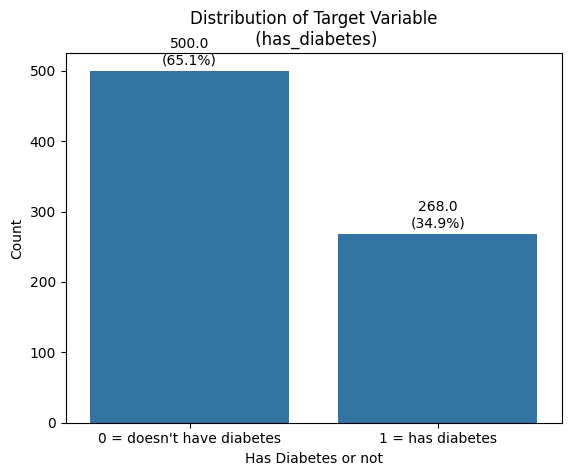

In [ ]:
# STEP 6) Data Understanding:

# 6.A) Target variable distribution:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your DataFrame and 'has_diabetes' is the target variable column
target_counts = df['has_diabetes'].value_counts()

# Create the bar plot
ax = sns.countplot(x='has_diabetes', data=df)
plt.xticks([0, 1], ["0 = doesn't have diabetes", "1 = has diabetes"])
plt.title('Distribution of Target Variable\n (has_diabetes)')
plt.xlabel('Has Diabetes or not')
plt.ylabel('Count')

# Add count and percentage labels to each bar
total_samples = len(df)
for p in ax.patches:
    count = p.get_height()
    percentage = f'{100 * count / total_samples:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 5  # Adjust vertical position of label
    ax.annotate(f'{count}\n({percentage})', (x, y), ha='center', va='bottom')

plt.show()



In [ ]:
# STEP 6) Data Understanding:

# 6.B) Scatterplot Correlations Overview

sns.pairplot(df)

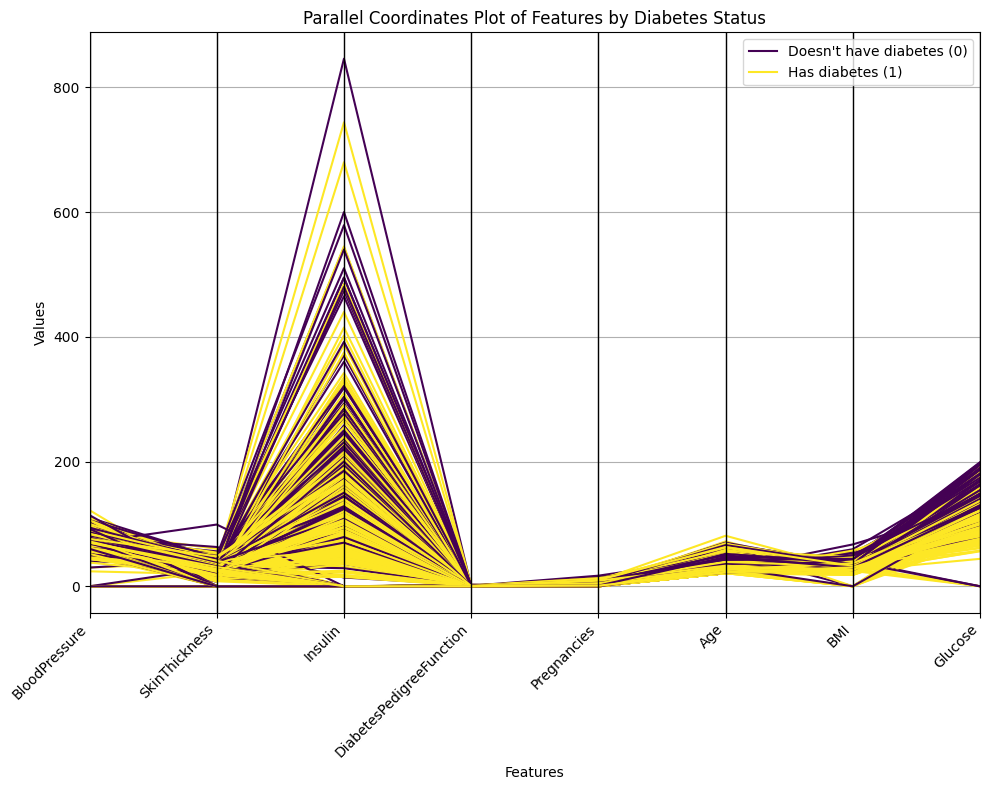

In this dataset, using the paralel coordinates to visualize the relationship of predictors
makes it difficult to see clear distinctions between the two classes (has diabetes and doesn't have diabetes)
based on the feature values. This could be due to overlapping values (The ranges of values for some features
might overlap between the two classes, making it hard to visually separate them), and because complex relationships
between features and the target variable might be complex and non-linear, making it difficult to capture them
with a simple parallel coordinates plot. So we will visualize further the predictors that show more correlation with the target as follows.


In [11]:
# STEP 6) Data Understanding:

# 6.C) Visualizing the relationship of variables to the target using parallel_coordinates

import pandas as pd

X = df
y = df["has_diabetes"]


# Calculate correlation with target variable
correlations = df.corr()['has_diabetes'].drop('has_diabetes')

# Order features based on absolute correlation (descending)
ordered_features = correlations.abs().sort_values(ascending=True).index

# Reorder columns in DataFrame
df_copy = df[['has_diabetes'] + list(ordered_features)]

# Create the parallel coordinates plot
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
pd.plotting.parallel_coordinates(df_copy, 'has_diabetes', colormap='viridis')

# Add legend
plt.legend(["Doesn't have diabetes (0)", "Has diabetes (1)"], loc='upper right')

# Rotate x-labels for better readability
plt.xticks(rotation=45, ha='right')

plt.title("Parallel Coordinates Plot of Features by Diabetes Status")
plt.xlabel("Features")
plt.ylabel("Values")
plt.tight_layout()
plt.show()

print("In this dataset, using the paralel coordinates to visualize the relationship of predictors\n"
"makes it difficult to see clear distinctions between the two classes (has diabetes and doesn't have diabetes)\n"
"based on the feature values. This could be due to overlapping values (The ranges of values for some features\n"
"might overlap between the two classes, making it hard to visually separate them), and because complex relationships\n"
"between features and the target variable might be complex and non-linear, making it difficult to capture them\n"
"with a simple parallel coordinates plot. So we will visualize further the predictors that show more correlation with the target as follows.")



In these plots we can clearly visualize the main direct and non direct correlations of the predictors
above/below correlation threshold set for this project of ±0.2 with the target variable has_diabetes.
Specifically in this database:

             Correlation with target has_diabetes
Glucose                                  0.466581
BMI                                      0.292695
Age                                      0.238356
Pregnancies                              0.221898 



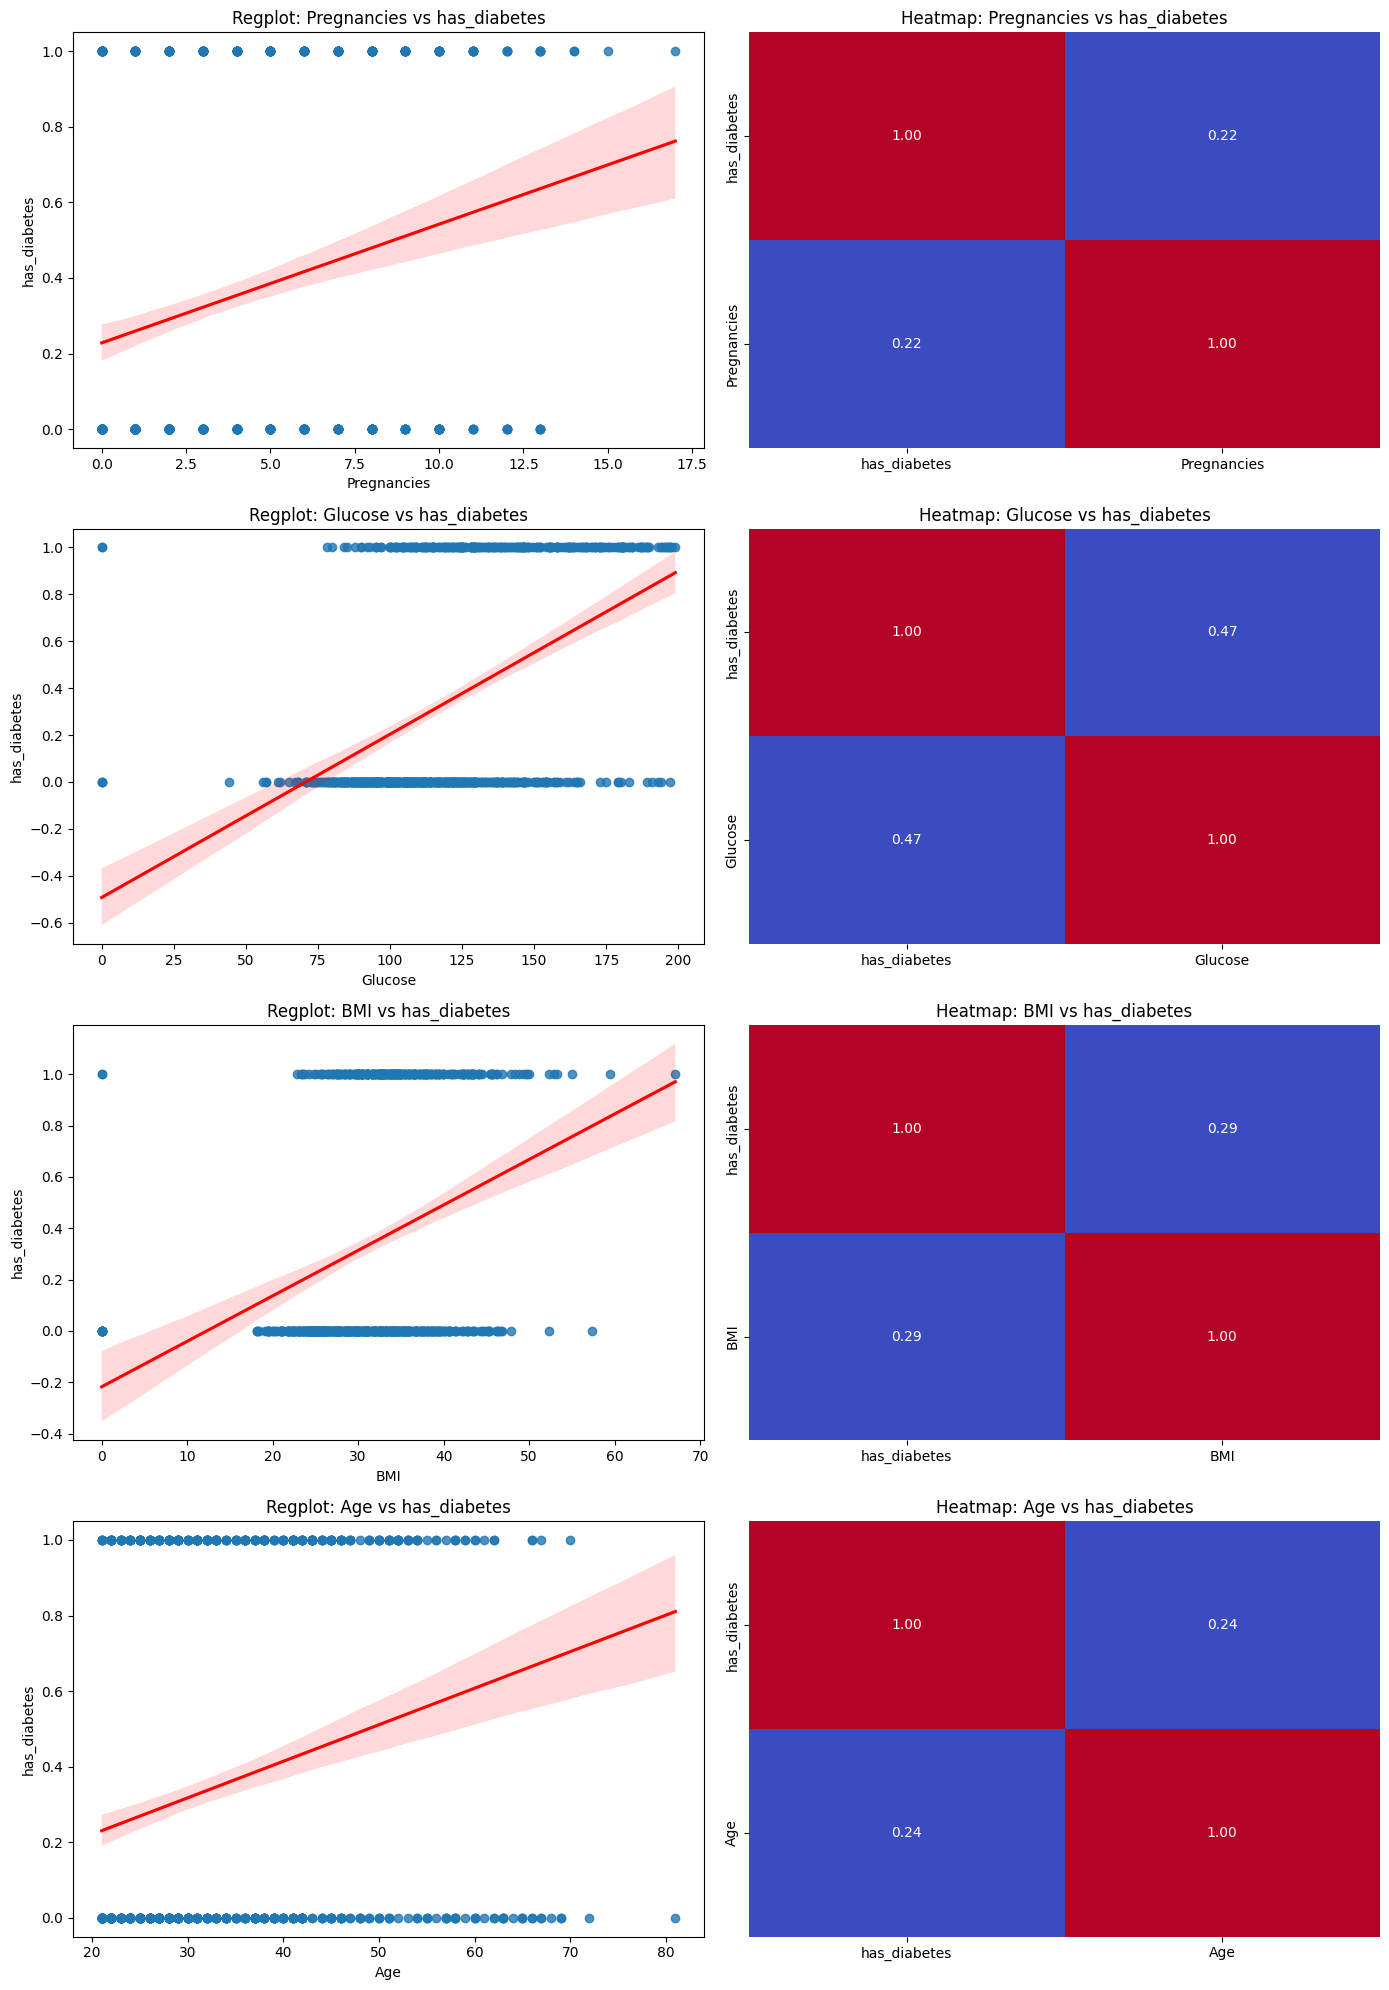

In [13]:
# STEP 6) Data Understanding:

# 6.D) Viusalizing correlation of most correlated predictors with the target:


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

target_variable = "has_diabetes"

# Drop the target variable from the DataFrame for correlation calculation
correlations_target = df.corr()[target_variable].drop(target_variable)
correlations_target

# Create a DataFrame to store the correlations
correlations_df = pd.DataFrame(correlations_target, columns=['Correlation with Target'])

# Drop the target variable row if present (it would have correlation 1 with itself)
correlations_df = correlations_df.drop(index=[target_variable], errors='ignore')


def plot_correlations_with_target(df, target_variable, correlation_threshold):
    """
    Plots scatter plots with regression lines (regplots) and heatmaps for predictors with a correlation
    above a threshold with the target variable. Also prints a table with the selected correlations.

    Args:
        df_correlations_with_target (pd.DataFrame): The DataFrame containing numerical features.
        target_variable (str): The name of the target variable column.
        correlation_threshold (float, optional): The minimum absolute correlation value to be considered. Defaults to 0.1.
    """
  # Calculate correlations with target variable and drop the target itself
    correlations = df.corr()[target_variable].drop(target_variable)

    # Sort correlations by absolute value in descending order
    correlations = correlations.abs().sort_values(ascending=False)

    # Filter correlations based on threshold
    correlations = correlations[correlations >= correlation_threshold]


    # Select predictors with correlation above or below the threshold
    selected_predictors = correlations_target[abs(correlations_target) > correlation_threshold]

    # Print a table of selected correlations
    print(f"\nIn these plots we can clearly visualize the main direct and non direct correlations of the predictors\n"
    f"above/below correlation threshold set for this project of ±{correlation_threshold} with the target variable {target_variable}.\n"
    "Specifically in this database:\n")
    correlation_table = selected_predictors.sort_values(ascending=False).to_frame()
    correlation_table.columns = [f'Correlation with target {target_variable}']
    print(correlation_table, "\n")

    # Create subplots grid for regplots and heatmaps
    num_plots = len(selected_predictors)
    num_rows = num_plots  # Each predictor gets one row (regplot + heatmap side by side)
    fig, axes = plt.subplots(num_rows, 2, figsize=(14, 5 * num_rows))

    # Handle case where there's only one predictor (axes won't be a 2D array)
    if num_plots == 1:
        axes = [axes]

    # Plot for each selected predictor
    for i, predictor in enumerate(selected_predictors.index):
        # Scatter plot with regression line (regplot)
        sns.regplot(
            ax=axes[i][0],
            data=df,
            x=predictor,
            y=target_variable,
            line_kws={"color": "red"}
        )
        axes[i][0].set_title(f"Regplot: {predictor} vs {target_variable}")

        # Heatmap for correlation between the predictor and the target variable
        sns.heatmap(
            df[[target_variable, predictor]].corr(),
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            cbar=False,
            ax=axes[i][1]
        )
        axes[i][1].set_title(f"Heatmap: {predictor} vs {target_variable}")

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


# Example usage
target_variable = 'has_diabetes'
correlation_threshold = 0.2

plot_correlations_with_target(df, target_variable, correlation_threshold)



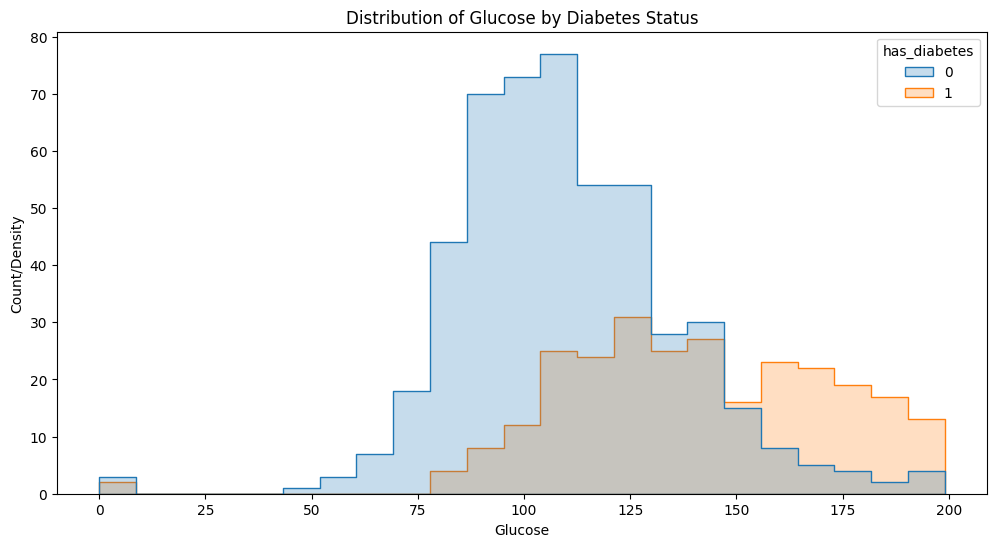

In [ ]:
# STEP 6) Data Understanding:

# 6.E) Zooming in the most related predictor to the target (Glucose)

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
# Use histplot with hue to show distribution of Glucose for each has_diabetes category
# or use boxplot to visualize the distribution of Glucose for each category
sns.histplot(data=df, x="Glucose", hue="has_diabetes", element="step")
#sns.boxplot(data=df, x="has_diabetes", y="Glucose") # Alternative for visualizing distribution
plt.title("Distribution of Glucose by Diabetes Status")
plt.xlabel("Glucose")
plt.ylabel("Count/Density") # Adjust based on plot type
# Update legend labels and include overlapping region
handles, labels = ax.get_legend_handles_labels()
labels = ["Doesn't have diabetes (0)", "Has diabetes (1)", "Overlapping Region"]
ax.legend(handles, labels, title="Diabetes Status")

plt.show()

In [ ]:
# STEP 7) Data Split (before feature selection using Decision Tree feature selection method itsel):

import pandas as pd
from sklearn.model_selection import train_test_split


X = df.drop(columns = "has_diabetes")
y = df["has_diabetes"]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [49]:

# STEP 8) Feature selection method using Decision Tree Importance 


from sklearn.tree import DecisionTreeClassifier
import pandas as pd

print(f"After previously analyzing and testing out the accuracy of different possibilities \n"
"(with and without feature selection using Mutual Info, selecting 3, 5 and 7 features) \n"
"without bringing accuracy above 0.68 (not even after optimizing each try), we will use\n"
"the following function to directly select features using the Decision Tree \n"
"feature selection method itelf, which seemed the most appropiate to be implemented in this dataset.")

def select_important_features(X_train, y_train, feature_names, importance_threshold, random_state):
    """
    Selects important features based on feature_importances_ from a DecisionTreeClassifier.
    
    Parameters:
        X_train (numpy.ndarray): Training predictor variables (features).
        y_train (numpy.ndarray): Training target variable.
        feature_names (list): List of feature names corresponding to X_train.
        importance_threshold (float): Minimum importance value to select a feature.
        random_state (int): Random seed for reproducibility.
    
    Returns:
        X_train_reduced (numpy.ndarray): Training data with only the important features.
        selected_features (list): Names of the selected features.
        feature_importances_df (pd.DataFrame): DataFrame showing all features and their importances.
    """
    # Train a decision tree on the training data
    model = DecisionTreeClassifier(random_state=random_state)
    model.fit(X_train, y_train)
    
    # Get feature importances
    importances = model.feature_importances_
    
    # Create a DataFrame for feature importances
    feature_importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Filter features by importance threshold
    selected_features = feature_importances_df[
        feature_importances_df['Importance'] > importance_threshold]['Feature'].tolist()
    
    # Reduce X_train to only include selected features
    selected_feature_indices = [feature_names.index(name) for name in selected_features]
    X_train_reduced = X_train[:, selected_feature_indices]
    X_train_reduced = pd.DataFrame(X_train[:, selected_feature_indices], columns=selected_features)
    return X_train_reduced, selected_features, feature_importances_df


    # Call the function with the column names of X

importance_threshold=0.085

X_train_reduced, selected_features, feature_importances_df = select_important_features(
    X_train.values,  # Convert DataFrame to NumPy array for the function
    y_train.values,  # Convert Series to NumPy array for the function
    X.columns.tolist(),  # Feature names from the original DataFrame
    importance_threshold,
    random_state=42
)

print("\n\n Selected Features:\n", selected_features)
print("\n \n Feature Importances:\n", feature_importances_df)

print("\n\n", X_train_reduced)

X_test_reduced = X_test[selected_features] 

X_test_reduced.head()



After previously analyzing and testing out the accuracy of different possibilities 
(with and without feature selection using Mutual Info, selecting 3, 5 and 7 features) 
without bringing accuracy above 0.68 (not even after optimizing each try), we will use
the following function to directly select features using the Decision Tree 
feature selection method itelf, which seemed the most appropiate to be implemented in this dataset.


 Selected Features:
 ['Glucose', 'BMI', 'BloodPressure', 'Age']

 
 Feature Importances:
                     Feature  Importance
1                   Glucose    0.314225
5                       BMI    0.170700
2             BloodPressure    0.147679
7                       Age    0.099215
6  DiabetesPedigreeFunction    0.083282
4                   Insulin    0.066253
3             SkinThickness    0.061164
0               Pregnancies    0.057482


      Glucose   BMI  BloodPressure   Age
0       84.0   0.0            0.0  21.0
1      112.0  28.2           82

,Glucose,BMI,BloodPressure,Age
668,98,34.0,58,43
324,112,35.7,75,21
624,108,30.8,64,21
690,107,24.6,80,34
473,136,29.9,90,50


In [50]:
type(X_test_reduced)


pandas.core.frame.DataFrame

In [51]:
X_train_reduced.head()

,Glucose,BMI,BloodPressure,Age
0,84.0,0.0,0.0,21.0
1,112.0,28.2,82.0,50.0
2,139.0,28.7,46.0,22.0
3,161.0,21.9,50.0,65.0
4,134.0,46.2,80.0,46.0


In [43]:
# EXE RESET

# Exe reset to allow comparsion between set with and without feature selection:

#STEP 1) Connect to the database and convert it to a dataframe
resource_url = "https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv"
df = pd.read_csv(resource_url, delimiter=',')


# STEP 4) Overall duplicates control:
print(f"Number of total rows before dropping duplicates: {df.shape[0]}")

#  STEP 4.B) Drop all duplicate occurrences
df.drop_duplicates(keep=False, inplace=True)
print(f"Number of total rows after dropping duplicates: {df.shape[0]}")
print(f"Total number of duplicated rows after dropping duplicates: {len(df[df.duplicated(keep=False)])}")

df = df.rename(columns = {'Outcome': 'has_diabetes'})

# STEP 8) Feature selection method using Decision Tree Importance 

X_train_reduced, selected_features, feature_importances_df = select_important_features(
    X_train.values,  # Convert DataFrame to NumPy array for the function
    y_train.values,  # Convert Series to NumPy array for the function
    X.columns.tolist(),  # Feature names from the original DataFrame
    importance_threshold=0.085,
    random_state=42
)

X_train_reduced.head()

Number of total rows before dropping duplicates: 768
Number of total rows after dropping duplicates: 768
Total number of duplicated rows after dropping duplicates: 0


,Glucose,BMI,BloodPressure,Age
0,84.0,0.0,0.0,21.0
1,112.0,28.2,82.0,50.0
2,139.0,28.7,46.0,22.0
3,161.0,21.9,50.0,65.0
4,134.0,46.2,80.0,46.0


In [39]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
60,2,84,0,0,0,0.0,0.304,21
618,9,112,82,24,0,28.2,1.282,50
346,1,139,46,19,83,28.7,0.654,22
294,0,161,50,0,0,21.9,0.254,65
231,6,134,80,37,370,46.2,0.238,46


In [52]:
# STEP 9) Saving and loading the data in csv

# Save X_train_reduced (features)
X_train_reduced.to_csv('X_train_reduced.csv', index=False)

# Save X_test_reduced (features)
X_test_reduced.to_csv('X_test_reduced.csv', index=False)

# Save y_train (target variable)
y_train.to_csv('y_train.csv', index=False)

# Save y_test (target variable)
y_test.to_csv('y_test.csv', index=False)

# Loading the saved CSV files back into DataFrames

# Load the features for training
X_train_reduced = pd.read_csv('X_train_reduced.csv')

# Load the features for testing
X_test_reduced = pd.read_csv('X_test_reduced.csv')

# Load the target variable for training
y_train = pd.read_csv('y_train.csv')

# Load the target variable for testing
y_test = pd.read_csv('y_test.csv')

X_train_reduced.head()

,Glucose,BMI,BloodPressure,Age
0,84.0,0.0,0.0,21.0
1,112.0,28.2,82.0,50.0
2,139.0,28.7,46.0,22.0
3,161.0,21.9,50.0,65.0
4,134.0,46.2,80.0,46.0


In [53]:
X_test_reduced.head()

,Glucose,BMI,BloodPressure,Age
0,98,34.0,58,43
1,112,35.7,75,21
2,108,30.8,64,21
3,107,24.6,80,34
4,136,29.9,90,50


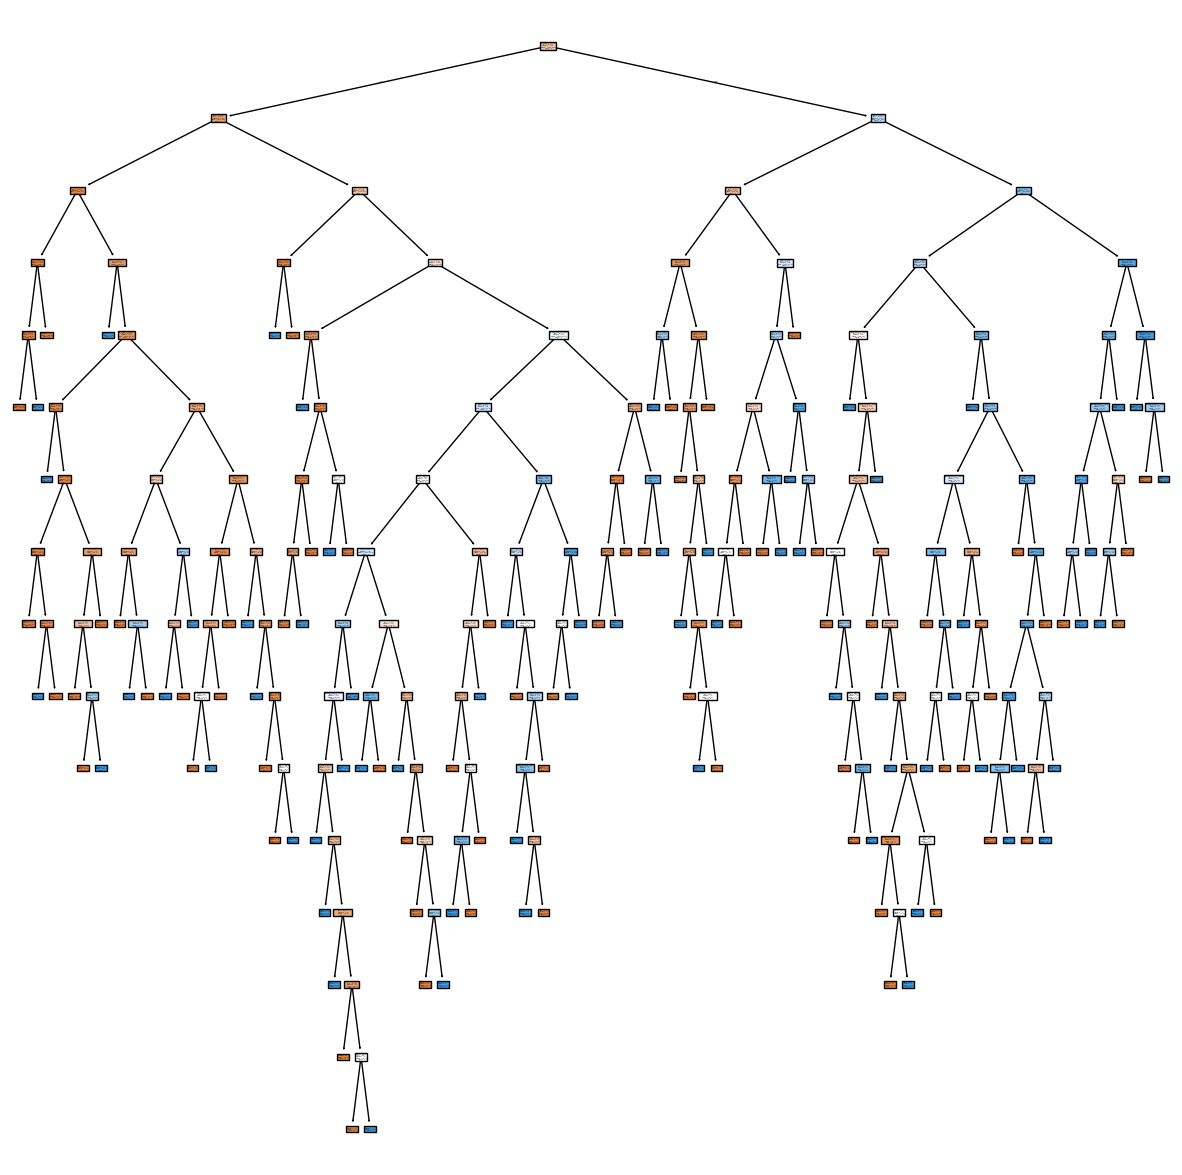


 
 Decision Tree Accuracy with 4 selected features above the importance treshold set in 0.085: 0.6883116883116883


In [54]:
# 10) Applying Decision Tree -again- to data set with just the selected features


# Traing again the Decision Tree just with the selected features:

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_reduced, y_train)

# Visualize the tree

from sklearn import tree

fig = plt.figure(figsize=(15,15))

tree.plot_tree(model, feature_names = list(X_train_reduced.columns), class_names = ["0", "1"], filled = True)

plt.show()

# Test the Decision Tree just with the selected features:
y_pred = model.predict(X_test_reduced)
y_pred


# Evaluate the Decision Tree just with the selected features:

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)

print(f"\n \n Decision Tree Accuracy with {len(selected_features)} selected features above the importance treshold set in {importance_threshold}: {accuracy}")

dump(model, open("decision_tree_regressor_with_decision_tree_feature_selection_42.sav", "wb"))



In [55]:
# 16) Model optimization

# 16.A) Setting all possible hyperparams for a Decision Tree


from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import numpy as np

hyperparams = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1,2, 4]
}

# 16.B) Applying GridSearch for hyperparam selection

grid = GridSearchCV(model, hyperparams, scoring = "accuracy", cv = 10)
grid




GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [56]:
# 16.C) Identifying best hyperparams

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

grid.fit(X_train, y_train)

print(f"Best hyperparameters: {grid.best_params_}")


Best hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [59]:
# 15.D) Applying best hyperparams to Decision Tree 

optimized_model = DecisionTreeClassifier(criterion =  "entropy", max_depth = 5, min_samples_leaf = 4, min_samples_split = 2, random_state=42)
optimized_model = model.fit(X_train,y_train)


# Optimized Model prediction

y_pred_2 = optimized_model.predict(X_test)


# 15.E) Comparing Accuracy before and after hyperparam optimization

# Evaluate the Decision Tree just with the selected features:

from sklearn.metrics import accuracy_score

optimized_accuracy = accuracy_score(y_test, y_pred_2)


print(f"\n \n Optimized Decision Tree Accuracy with {len(selected_features)} selected features using Decision Tree Importance: {optimized_accuracy}")
print(f"\n \n Decision Tree Accuracy with {len(selected_features)} selected features using Decision Tree Importance: {accuracy}")

dump(model, open("optimized_decision_tree_regressor_with_decision_tree_feature_selection_42.sav", "wb"))




 
 Optimized Decision Tree Accuracy with 4 selected features using Decision Tree Importance: 0.7467532467532467

 
 Decision Tree Accuracy with 4 selected features using Decision Tree Importance: 0.6883116883116883


In [60]:
from pickle import dump

dump(model, open("decision_tree_regressor_with_decision_tree_feature_selection_42.sav", "wb"))